<font size='6px'>
📝 <b>GAN Tutorial: A Gentle Mathematical dan Deep Learning Implementation Intro to Generative Adversarial Network (GAN) for P-Phase Detection</b></font>

<font color='orange'> **written by Rai--** </font>

# 0. What This Notebook Tells

# 1. Introduction: Mathematical Framework (important!)

Generative Adversarial Network is a deep learning architecture with two models that are trained adversely. These two models are generative and discriminative model. The generative model aims to *deceive* the discriminative model by generating an artificial data that resembles the distribution of a data in the given dataset. In contrast, discriminative model learns how to distinguish the real data from the dataset with the data from the generation.

Before delving into the codes, we need to have strong mathematical backgrounds of the underlying process in GAN. In this section, we will go through with the mapping functions of the models, the mathematical modelling of GAN's objectives, and GAN's loss functions.

### The Mapping

The main idea of the generative adversarial network is the adversarial training. The generative model takes a small noise data and upsamples them until it matches the dataset data shape. Let's define $G$ as our mapping operator that does this. In this case, $G$ stands for generative. Let's also define $\vec{x}^{(0)}$ as our **latent sample** and $\vec{x}^{(g)}$ (the supscript $g$ stands for 'generated') as the output of our generator model, the artifical data. The following equation is satisfied.

\begin{equation}
G : \vec{x}^{(0)} \mapsto \vec{x}^{(g)}, \quad G:\mathbb{R}^L \mapsto \mathbb{R}^N.
\end{equation}

From the equation above, $L$ and $N$ are consecutively the dimesionality of our latent sample vector and seismic waveform vector. Remember that our waveform is a time-series data, hence it can be represented in a vector.

A discriminative model takes the artificial data, $\vec{x}^{(g)}$, and the dataset data, $\vec{x}_i^{(d)}$ (the superscript $d$ stands for 'dataset' and the subscript stands for the $i^\mathrm{th}$ of the data in the dataset). Both of these vectors are having identical space. Let's define $D$ as our mapping operator that would map $\mathbb{R}^N$ to $\mathbb{R}$. Our formal definition is stated in the following equation.

\begin{align}
D:\vec{x}^{(g)} &\mapsto d, \quad D:\mathbb{R}^N \mapsto \mathbb{R} \\
D:\vec{x}^{(d)}_i &\mapsto d_i
\end{align}

The value $d$ is a scalar ranging from 0 to 1 that represents the confidence of the P-wave detection.

### The Objective: Min-Max Game

The adversary characteristic in the GAN models signify that there is some sort-of two objective measurements where the two are anti to one another. We have discussed that the generative model is trained to deceive the discriminative. Concurrently, discriminative model must be able to discern the artifical data and the real one. From the generative model perspective, the objective measurement or **value function** can be seen in the following way of a min-max game.

\begin{equation*}
J_G = \min_G \max_D \left( \mathbb{E}_{\vec{x}^{(0)}_i \sim \;p_\text{gauss}} \log\left[1 - D\left(G\left(\vec{x}^{(0)}_i\right)\right)\right] + \mathbb{E}_{\vec{x}^{(d)} \sim \; p_\text{data}} \log D\left(\vec{x}^{(d)}_i\right)\right)
\end{equation*}

The variable $p_\text{gauss}$ and $p_\text{data}$ from the equation above are the gaussian distribution and the distribution induced by the dataset. The subscript notation for $\vec{x}_i^{(0)}$ and $\vec{x}_i^{(d)}$ signify that we are drawing the $i^\mathrm{th}$ row vector of our dataset accordingly which are $\mathbf{X}^{(0)}$ for the latent sample matrix and $\mathbf{X}^{(d)}$ for the dataset matrix. We don't consider the batch size at the moment for the sake of simplicity.


Next up, we pay close attention to the minmax notation in the equation. Our objective is to minimize the function of the first expectation value (let's name it $f^{(g)}(\vec{x}^{(0)}_i)$) when training $G$. At the same time, we train $D$ to maximize the function of the second expectation value (let's name it $f^{(d)}(\vec{x}^{(d)}_i)$).

The reason why we minimize and maximize the certain function is due to the objective we set. As we train $G$, we want $D\left(G\left(\vec{x}_i^{(0)}\right)\right) \rightarrow 1$. This causes $f^{(g)}$ to be minimized. On the contrary, when training $D$, we want $D\left(\vec{x}_i^{(d)}\right)$ to approach one, hence maximizing $f^{(d)}$.

#### Mathematical Review: Expectation Value for drawing $\mathcal{X}$ from $p(\mathcal{X})$ for $f(x)$ with $x \in \mathcal{X}$

Mathematically, if we have a $\mathcal{X}$ that is sampled from $p(\mathcal{X})$ with $p$ is some probabilistic distribution, the expectation value of $f(x)$ with $f$ as some mapping function is

\begin{align*}
\mathbb{E}_{x \; \sim \; p(x)}f(x) &\approx \sum_{x \in \mathcal{X}} f(x)u(x) \\
&= \int_{x \in \mathcal{X}} f(x)u(x) dx
\end{align*}

From these two equations, we may write formally that the objective measurement is as follow.

\begin{equation*}
J_G = \sum_{i}p_\text{gauss}(\vec{x}^{(0)}_i) \log\left [1-D\left(G\left(\vec{x}^{(0)}_i\right)\right)\right] + \sum_{i}p_\text{data}(\vec{x}^{(d)}_i) \log D \left(\vec{x}_i^{(d)}\right)
\end{equation*}

# 2. Deep Learning Implementations

In this part, we will implement the theoretical framework of the GAN model by designing the generative model and discriminative model, defining their losses, and defining their backpropagation behaviors.

## Model Construction

As what we have discussed earlier, we have generative and discriminative model with its corresponding mapping operator $G$ and $D$. In this section, we will try to create these mapping operator using neural network approach. We won't jump into details on how the mathematical background in the forward propagation flows, assuming we already understand them.

### Generative Model: $G: \mathbb{R}^{L} \mapsto \mathbb{R}^{N}$

We create a latent sample $\mathbf{X}^{(0)} \sim \mathcal{N}(\mu, \sigma)$. You may adjust $\mu$ (the average of the normal distribution) and $\sigma$ (the standard deviation of the normal distribution) according to your hyperparameter tuning necessity. Let's import TensorFlow libary first and assign the global variables required for the generative model.

In [2]:
# We import tensorflow firstimport logging
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv1DTranspose, Input, Flatten, Conv1D, \
AveragePooling1D

# These are the required global vars for model G.
# All of these vars are adjustable.
# Adjust these accordingly to your needs.
mu = 0
sigma = 1
L = 50 # the latent sample size
N = 350 # the window length of GAN
B = 100 # the batch size

tf.random.set_seed(6969)

IMPORTANT! Make sure the GPU is enabled. If this prints an empty list, you are not running a GPU.

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


And now let's create $\mathbf{X}^{(0)} \in \mathbb{R}^{B\times L}$.

In [6]:
# We draw X from the normal distribution
X0 = tf.random.normal(shape=(B, L), mean=mu, stddev=sigma)

print(f'X^0 is in the real space of {tf.shape(X0)[0]} x {tf.shape(X0)[1]}')

X^0 is in the real space of 100 x 50


#### Dense Layer Approach

A dense layer can be utilized to do the upsampling process. The last layer of the dense layer is set to have a unit of $N$ to represent $\mathbb{R}^{N}$.

##### Mathematical Review on Dense Layer (Optional)

A dense layer can be seen as a mapping function. We operate our input in the form of a vector to our operator, $\mathbf{W}$, which is the weight matrix, to get the output. Additionally, a bias usually is added to the operation.

Suppose we have an input vector $\vec{x}^{(n-1)} \in \mathbb{R}^A$  and a weight matrix $\mathbf{W}^{(n)}$. The operation of this $n^\mathrm{th}$ dense layer is

\begin{align}
\mathbf{W}^{(n)}:\mathbb{R}^A &\mapsto \mathbb{R}^B \\
\mathbf{W}^{(n)}:\vec{x}^{(n-1)} &\mapsto \vec{x}^{(n)} \\
&\mapsto \vec{x}^{(n-1)\top}\mathbf{W}^{(n)}
\end{align}

The value of $B$ is determined by the total units or neurons assigned to dense layer at $n^\mathrm{th}$. Along with that, considering the bias, the following equation holds.

$$\mathbf{W}^{(n)} : \vec{x}^{(n-1)} \mapsto \vec{x}^{(n-1)\top}\mathbf{W}^{(n)} + \vec{b}^{(n)\top}$$

Finally, an activation function $\sigma$ is applied element-wisely.

##### Implementation

In [7]:
# The input layer is a vector in R^L space.
input_layer = Input(shape=(L,))
cont = Dense(100, activation='relu', name='dense0')(input_layer)
cont = Dense(200, activation='relu', name='dense1')(cont)
cont = Dense(300, activation='relu', name='dense2')(cont)

# The output layer is a vector in R^N space.
output_layer = tf.keras.layers.Dense(N, name='dense3')(cont)

In [8]:
# We create the generative model with tf.keras.Model module.
g_model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# We print our model summary
print(g_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense0 (Dense)                  │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 350)            │       105,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,950 (745.90 KB)

 Trainable params: 190,950 (745.90 KB)

 Non-trainable params: 0 (0.00 B)

None


Now let's test it out whether our mapping operator $G$ works.

In [9]:
# We pick the second index of the latent sample to be mapped.
# This pick is random.
x0_1 = X0[1]
print(f'The vector space before mapping: R^{tf.shape(x0_1)[0]}')

# The following code won't work because a model in TensorFlow works
# in batch.
# g_model(x0) # WONT WORK!

# Now we map it.
xg_1 = g_model(tf.expand_dims(x0_1, axis=0))

# xg_1 is having a shape of 1x350 with 1 is the batch size.
print(f'The vector space after mapping: R^{tf.shape(xg_1)[1]}')

The vector space before mapping: R^50
The vector space after mapping: R^350


#### 1D Convolution Transpose Approach

Another way to do the upsampling process is by using 1D convolution transpose (the anti-convolution). We do the same process by repeatedly upsample the latent sample.

##### Mathematical Review on Convolution 1D Transpose (Optional)

Convolution 1D Transpose maps $\mathbb{R}^A \mapsto \mathbb{R}^B$ with $B > A$. Suppose we have an input vector $\vec{x}^{(0)}$ in space $\mathbb{R}^A$ and an output vector $\vec{x}^{(1)}$ in space $\mathbb{R}^B$. Suppose we also have a kernel of $\mathbf{K} \in \mathbb{R}^{K\times C}$ with $K$ as the kernel size and $N$ as the channel number. Let's work on a very simple case where we have $\vec{x}^{(0)} \in \mathbb{R}^3$ and $\vec{k} \in \mathbb{R}^3$.

<img src="gan_tutorial_img/deconv1d.jpg" width="1000px"></img>

From the image above, we can see that each of the element of the mapped vector is the convolution process of each element in the input vector with the kernel. We may state

\begin{align}
x^{(1)}_{0} &= k_0 x_0^{(0)} \\
x^{(1)}_1 &= k_1 x^{(0)}_0 + k_0 x^{(0)}_1 \\
x^{(1)}_2 &= k_2 x^{(0)}_0 + k_1 x^{(0)}_1 + k_0x^{(0)}_2 \\
x^{(1)}_3 &= \phantom{k_2 x^{(0)}_0} + k_2 x^{(0)}_1 + k_1x^{(0)}_2 \\
x^{(1)}_4 &= \phantom{k_2 x^{(0)}_0 + k_2 x^{(0)}_1} + k_2x^{(0)}_2  \\
\end{align}

We can express the equation in matrix form

\begin{equation}
\vec{x}^{(1)} =
\vec{x}^{(0)\top}
\begin{bmatrix}
k_0   & 0     & 0 \\
k_1   & k_0   & 0 \\
k_2   & k_1   & k_0 \\
0     & k_2   & k_1 \\
0     & 0     & k_2
\end{bmatrix}^\top
\end{equation}

This is simply $\mathbf{K} : \vec{x}^{(0)} \mapsto \vec{x}^{(1)}$. If the kernel has multiple filters, therefore the mapping becomes $\mathbf{K} : \vec{x}^{(0)} \mapsto \mathbf{X}^{(1)}$ where $\mathbf{K}$ is in $\mathbb{R}^{K\times C}$ space and $\mathbf{X}^{(1)}$ is in $\mathbb{R}^{B\times C}$ space.

##### Implementation

In [19]:
'''
The input layer is a vector in R^L space.
If previously we only pass shape=(50,), this time we need to assign the parameter
shape of the input layer with (50,1). Although mathematically this also means a
vector, TensorFlow regards this as a "channel". This is the requirement for
passing the tensor into a Conv1DTranspose layer.

Alternatively, we can still maintain shape=(50,) as the input layer, but we need
to use the following customized layer to expand it.
'''

@tf.keras.utils.register_keras_serializable(
    package="gan-tutorial",
    name="VecAddChannel",
)
class VecAddChannel(tf.keras.Layer):
  def __init__(sf):
    # The method called when the class's object is initiated.

    # We call the parent's constructor
    super().__init__()

  def build(sf, input_shape):
    # This method usually contains trainable weights. We won't add
    # any for this layer.
    pass

  def call(sf, input):
    # We returned its expanded dims form.
    return tf.expand_dims(input, axis=-1) 

In [12]:
input_layer = tf.keras.layers.Input(shape=(L,))
expanded = VecAddChannel()(input_layer)
cont = Conv1DTranspose(filters=1, kernel_size=5, strides=1)(expanded)
cont = Conv1DTranspose(filters=5, kernel_size=8, strides=1)(cont)
cont = Conv1DTranspose(filters=7, kernel_size=8, strides=1)(cont)
cont = Conv1DTranspose(filters=5, kernel_size=3, strides=1)(cont)

# We flatten the space.
output_layer = Flatten()(cont)

In [10]:
# We create the generative model with tf.keras.Model module.
# We need to make sure the flattened space is R^N.
g_model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# We print our model summary
g_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vec_add_channel (VecAddChannel) │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 54, 1)          │             6 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 61, 5)          │            45 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 68, 7)          │           287 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 70, 5)          │           110 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 350)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448 (1.75 KB)

 Trainable params: 448 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

Same as before, let's test it out.

In [14]:
# We pick the second index of the latent sample to be mapped.
# This pick is random.
x0_1 = X0[1]
print(f'The vector space before mapping: R^{tf.shape(x0_1)[0]}')

# The following code won't work because a model in TensorFlow works
# in batch.
# g_model(x0) # WONT WORK!

# Now we map it.
xg_1 = g_model(tf.expand_dims(x0_1, axis=0))

# xg_1 is having a shape of 1x350 with 1 is the batch size.
print(f'The vector space after mapping: R^{tf.shape(xg_1)[1]}')

The vector space before mapping: R^50
The vector space after mapping: R^350


#### Mixed Method

Mixing dense layer and convolutional 1D transpose can be done. Basically you can use any method to construct the mapping function $G$ as long as the input and the output space comply $G: \mathbb{R}^L \mapsto \mathbb{R}^N$. You may even incorporate the downsampling layers within the process such as 1D average pooling or 1D convolution. In this case, we will settle down with the following generative model. **You may want to hypertune or modify this model according to your necessity**. There is no set of rule of how to construct a model that guarantees good model performance after the training.

The following method is used to create a customized Leaky Rectified Linear Unit (Leaky ReLU). By default a relu can be expressed as:

\begin{equation}
\sigma(x) = 
\begin{cases}
    0.01x,          & \text{if } x \leq 0\\
    x,              & \text{otherwise}
\end{cases}
\end{equation}

The following method allows you to tune two the leaky relu variables $a,b \in \mathbb{R}^+$ as such:

\begin{equation}
\sigma(x; a,b) = 
\begin{cases}
    ax,             & \text{if } x \leq 0 \\
    bx,             & \text{otherwise}
\end{cases}
\end{equation}

In [18]:
@tf.keras.utils.register_keras_serializable(
    package="gan-tutorial",
    name="ab_leaky_relu",
)
def ab_leaky_relu(a, b):
  def proc(x):
    # x is a tensor. The process is element-wise.

    # We obtain all the negative values and its corresponding indices in the
    # tensor.
    negative_values = tf.boolean_mask(x, x < 0)
    negative_values_idc = tf.where(x < 0)

    # We obtain all the positive values and its corresponding indices in the
    # tensor.
    positive_values = tf.boolean_mask(x, x >= 0)
    positive_values_idc = tf.where(x > 0)

    # We multiply all of the negative values by 'a' and all of the positive
    # values by 'b'
    negative_values *= a
    positive_values *= b

    # update all of the negative values
    new_x = tf.tensor_scatter_nd_update(tensor=x, 
                                        indices=negative_values_idc,
                                        updates=negative_values)

    # update all of the positive values
    new_x = tf.tensor_scatter_nd_update(tensor=new_x, 
                                        indices=positive_values_idc,
                                        updates=positive_values)

    return new_x
  return proc

In [20]:
# Generative model

input_layer = tf.keras.layers.Input(shape=(50,))
expanded = VecAddChannel()(input_layer)

# begin deconvolution 
cont = Conv1DTranspose(filters=2, kernel_size=7, 
                       activation=ab_leaky_relu(0.1,1))(expanded)
cont = Conv1DTranspose(filters=4, kernel_size=12,
                       activation=ab_leaky_relu(0.1,1))(cont)
cont = Conv1DTranspose(filters=8, kernel_size=16,
                       activation=ab_leaky_relu(0.1,1))(cont)
cont = Conv1DTranspose(filters=6, kernel_size=12,
                       activation=ab_leaky_relu(0.1,1))(cont)

# exit deconvolution, begin fully-connected
cont = Flatten()(cont)
cont = Dense(400, activation=ab_leaky_relu(0.1,1))(cont)
cont = Dense(350, activation='tanh')(cont)

# construct the model
g_model = tf.keras.Model(inputs=[input_layer], outputs=[cont])

g_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vec_add_channel_2               │ (None, 50, 1)          │             0 │
│ (VecAddChannel)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 56, 2)          │            16 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 67, 4)          │           100 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 82, 8)          │           520 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 93, 6)          │           582 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 558)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 400)            │       223,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 350)            │       140,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,168 (1.39 MB)

 Trainable params: 365,168 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Let's test it out real quick.

In [17]:
# We pick the second index of the latent sample to be mapped.
# This pick is random.
x0_1 = X0[1]
print(f'The vector space before mapping: R^{tf.shape(x0_1)[0]}')

# The following code won't work because a model in TensorFlow works
# in batch.
# g_model(x0) # WONT WORK!

# Now we map it.
xg_1 = g_model(tf.expand_dims(x0_1, axis=0))

# xg_1 is having a shape of 1x350 with 1 is the batch size.
print(f'The vector space after mapping: R^{tf.shape(xg_1)[1]}')

The vector space before mapping: R^50
The vector space after mapping: R^350


And this is the generated waveform sampled from the latent space prior to model training.

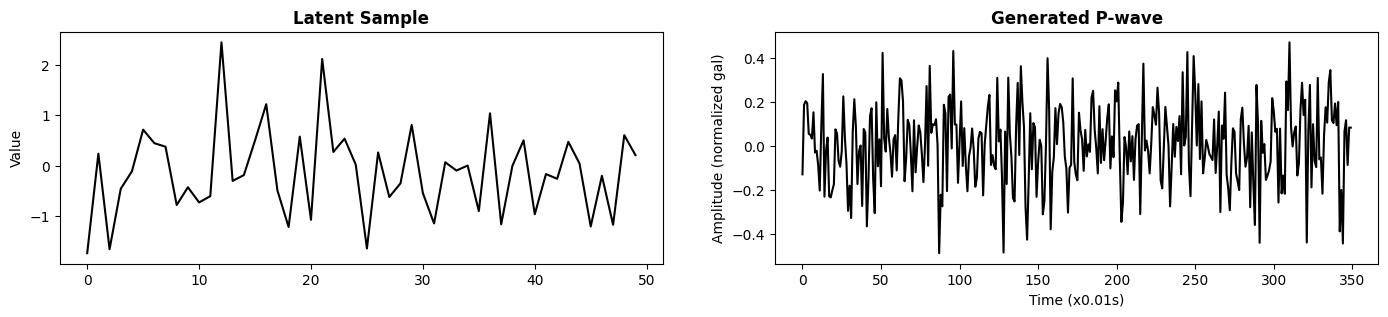

In [18]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2, figsize=(15,4))
f.tight_layout(pad=5)
ax[0].plot(X0[1], color='black')
ax[0].set_ylabel('Value')
ax[0].set_title('Latent Sample', fontweight='bold')

ax[1].plot(g_model(X0[1:2])[0], color='black')
ax[1].set_xlabel('Time (x0.01s)')
ax[1].set_ylabel('Amplitude (normalized gal)')
ax[1].set_title('Generated P-wave', fontweight='bold')

plt.show()

### Discriminative Model: $D:\mathbb{R}^N \mapsto \mathbb{R}$

The discriminative model is the oppositon of generative model as what he have discussed. It maps a P-wave waveform vector (time-series) to a scalar with a value ranging from 0 to 1. In terms of deep-learning context, we require a neural network that downsamples our data. Since we are dealing with a vector, we could use 1D convolution or a dense layer.

In [21]:
# Discriminative model

input_layer = Input(shape=(350,))
expanded = VecAddChannel()(input_layer)

# Begin convolution
cont = Conv1D(filters=3, kernel_size=5, activation=ab_leaky_relu(0.1,1))(expanded)
cont = Conv1D(filters=4, kernel_size=8, activation=ab_leaky_relu(0.1,1))(cont)
cont = Conv1D(filters=3, kernel_size=10, activation=ab_leaky_relu(0.1,1))(cont)
cont = AveragePooling1D(pool_size=2)(cont)

# exit convolution, begin fully-connected
cont = Flatten()(cont)
cont = Dense(256, activation=ab_leaky_relu(0.1,1))(cont)
cont = Dense(128, activation=ab_leaky_relu(0.1,1))(cont)
cont = Dense(64, activation=ab_leaky_relu(0.1,1))(cont)
cont = Dense(32, activation=ab_leaky_relu(0.1,1))(cont)
cont = Dense(1, activation='sigmoid')(cont)

# construct the model
d_model = tf.keras.Model(inputs=[input_layer], outputs=[cont])

d_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vec_add_channel_3               │ (None, 350, 1)         │             0 │
│ (VecAddChannel)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 346, 3)         │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 339, 4)         │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 330, 3)         │           123 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 165, 3)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 495)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       126,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,482 (665.95 KB)

 Trainable params: 170,482 (665.95 KB)

 Non-trainable params: 0 (0.00 B)

And now let's test them out. Let's take the following process.

\begin{align}
G:\mathbb{R}^L &\mapsto \mathbb{R}^N \\
D:\mathbb{R}^N &\mapsto \mathbb{R}
\end{align}

In [21]:
# taking a random latent sample
k = 19
x0_k = X0[k]
print(f'Latent sample space: R^{tf.shape(x0_k)[0]}')

# mapping the latent space to the waveform's space
xg_k = g_model(tf.expand_dims(x0_k, 0))
print(f"Generated P-wave's space: R^{tf.shape(xg_k)[1]}")

# mapping the waveform's space to a scalar space
d_k = d_model(xg_k)
print(f'Probability value space: R^{tf.shape(d_k)[1]}')

Latent sample space: R^50
Generated P-wave's space: R^350
Probability value space: R^1


#### Mathematical Reviews on One-Dimension Convolution and Average Pooling (Optional)

##### Convolution 1D

The one-dimensional convolution process is the inverse process of the one-dimensional deconvolution. For instance, assume we are having stride = 1 and suppose we have an input vector $\vec{x}^{(0)} \in \mathbb{R}^5$ and an output vector $\vec{x}^{(1)} \in \mathbb{R}^3$ with the kernel $\vec{k} \in \mathbb{R}^3$. The following image represents the convolutional process for stride = 1.

<img src='gan_tutorial_img/conv1d.jpg' width='1000px'></img>



The following equations describe the output values.
\begin{align}
x^{(1)}_0 &= k_0 x^{(0)}_0 + k_1 x^{(0)}_1 + k_2 x^{(0)}_2 \\
x^{(1)}_1 &= \phantom{k_0 x^{(0)}_0} + k_0 x^{(0)}_1 + k_1 x^{(0)}_2 + k_2 x^{(0)}_3 \\
x^{(1)}_2 &= \phantom{k_0 x^{(0)}_0 + k_0 x^{(0)}_1}  + k_0 x^{(0)}_2 + k_1 x^{(0)}_3 + k_2 x^{(0)}_4 
\end{align}
We can sumarize the equations above in the following matrix form.
\begin{align}
\vec{x}^{(1)} &= \begin{bmatrix}
k_0 & k_1 & k_2 & 0  & 0 \\
0   & k_0 & k_1 & k2 & 0 \\
0   & 0   & k_0 & k_1 & k_2
\end{bmatrix}\vec{x}^{(0)}
\end{align}
In deep-learning, we usually deal with row vector. We transform it into the following equation.
\begin{align}
\vec{x}^{(1)\top} &= \vec{x}^{(0)\top}\begin{bmatrix}
k_0 & 0   & 0 \\
k_1 & k_0 & 0 \\
k_2 & k_1 & k_0 \\
0   & k_2 & k_1 \\
0   & 0   & k_2 \\
\end{bmatrix} \\
\vec{x}^{(1)\top} &= \vec{x}^{(0)\top} \mathbf{K}
\end{align}
This operation is no other than a matrix multiplication that have discussed earlier. We can say $\mathbf{K}:\vec{x}^{(0)} \mapsto \vec{x}^{(1)}$. The matrix $\mathbf{K}$ is trainable.

##### Average Pooling 1D

A pooling layer is usually used in the down-sampling process and feature extraction. For this particular case, as usual, let's define our input vector $\vec{x}^{(0)} \in \mathbb{R}^8$ and the output vector $\vec{x}^{(1)} \in \mathbb{R}^4$. We use a pooling size of 2. The average pooling process can be seen from the image below.

<img src="gan_tutorial_img/pool.jpg" width="800px"></img>

For each vector element of the output, the following equations satisfy.
\begin{align*}
x^{(1)}_0 = \frac{1}{2}\left(x^{(0)}_0 + x^{(0)}_1\right) \\
x^{(1)}_1 = \frac{1}{2}\left(x^{(0)}_2 + x^{(0)}_3\right) \\
x^{(1)}_2 = \frac{1}{2}\left(x^{(0)}_4 + x^{(0)}_5\right) \\
x^{(1)}_3 = \frac{1}{2}\left(x^{(0)}_6 + x^{(0)}_7\right)
\end{align*}
More generally, we may state
\begin{equation*}
x^{(1)}_i = \frac{1}{a}\sum_{i=2a}^{3a} x^{(0)}_i
\end{equation*}
The value of $a$ is the pooling size. Note that this only applies for stride = 1. Unlike the others, this layer does not have any trainable parameters or weights.

## Loss Functions

### Binary Cross Entropy

In the binary classification problem, we use the binary cross entropy loss. We calculate $\mathcal{L}_\mathrm{BCE}$ via the following expression (BCE stands for Binary Cross Entropy).
\begin{equation*}
\mathcal{L}_\mathrm{BCE}(\vec{y}, p(\vec{y})) = - \sum_i y_i \log(p(y_i)) + (1-y_i)\log(1-p(y_i))
\end{equation*}
$p(y_i)$ is derived from $p : y_i$. In the deep learning context, the operator $p$ is the neural network model. The value of $p(y_i)$ is expected to be $[0, 1]$ and $y_i \in \{0, 1\}$. From the given equation, the value of $\mathcal{L}_\mathrm{BCE}$ is minimum when $p(y_i) \rightarrow y_i$, otherwise, it increases. To validate it, try to assign the extreme conditions. We will have $\mathcal{L}_\mathrm{BCE}\rightarrow \infty$ if $y_i = 0$ and $p(y_i) = 1$ or otherwise. In contrast, if $y_i = p(y_i)$ we have $\mathcal{L}_\mathrm{BCE} = 0$.

### Discriminative Model

The loss function for the discriminative model can be derived from the binary cross entropy case. We want $D$ to output $0$ if data the input is sampled from $p_g$ (generator model) or $p_\text{noise}$. Let's define a vector $\vec{x}'_i \sim p_g, p_\text{noise}$. This notation means that vector $\vec{x}'_i$ is sampled from generative P-wave distribution and noise distribution from the dataset. Subsequently, let's define $\vec{x}_i \sim p_\text{data}$. Just to clarify, $\vec{x}'_i \subset \mathbf{X}'$ and $\vec{x}_i \subset \mathbf{X}$.

At this point, we want to clarify something in the first place. We have not seen $p_\text{noise}$ before as earlier in the theoretical framework, we do not bother to use the noise dataset. The discriminative is trained with pure P-wave dataset and generative P-wave. This is a modification to the original GAN training initiated by the author of this notebook. But either way, the principle holds the same thing. We consider both the noise form the dataset and the generative P-wave as a non-P-wave data. We may then proceed to the following equation that defines the loss of the discriminative model.
\begin{equation*}
\mathcal{L}_D(\mathbf{X}, \mathbf{X}') = \mathcal{L}_\mathrm{BCE}(0,D(\mathbf{X}')) + \mathcal{L}_\mathrm{BCE}(1, D(\mathbf{X}))
\end{equation*} 
If you pay close attention to the equation above, you should notice that the loss function does not incorporate any labels whereas based on our previous definition of BCE loss function, we require the label from the dataset. How is this possible? In principle, what the equation above does is no other than the simplificataion of the previous loss function. We know that $\vec{x}'_i \sim p_g, p_\text{noise}$ and therefore, $\vec{y}'$ should be $\vec{0}$. On the other hand, we know that $\vec{x} \sim p_\mathrm{data}$ and therefore, $\vec{y} = \vec{1}$. Buy plugging this to the BCE loss function, we satisfy the equation above. Furthermore, we can expand it to this following form.
\begin{equation*}
\mathcal{L}_D(\mathbf{X}, \mathbf{X}') = -\sum_i \log(1-D(\vec{x}'_i)) + \log(D(\vec{x}_i))
\end{equation*}

In [22]:
@tf.function # adding decorator to accelerate training later
def calc_d_loss(X, X_prime, d_model):
  # Variable x and x_prime are R^(BxN) with B is the batch size.
  # We devide the equation above into two terms.
  
  # Define epsilon to avoid nan
  eps = 1e-6
  
  # First term:
  first_term = tf.math.log(1 - d_model(X_prime) + eps) # shape: B x 1

  # Second term:
  second_term = tf.math.log(d_model(X) + eps) # shape: B x 1

  # Total loss
  loss = first_term + second_term # shape: B x 1
  loss = tf.math.reduce_sum(loss, axis=0) # shape: 1
  loss = - 1* loss[0] # scalar

  return loss

### Generative Model

The generative model's goal is to trick the discriminative model. We want $D(\vec{x}') \rightarrow 1$ for $\vec{x}' \sim p_g$ and therefore
\begin{align*}
\mathcal{L}_G(\mathbf{X}^{(0)}) &= \mathcal{L}_\mathrm{BCE}\left(1, D\left(G\left(\mathbf{X}^{(0)}\right)\right)\right) \\
&= - \sum_i \log D\left(G\left(\vec{x}^{(0)}_i\right)\right)
\end{align*}
During training, we don't use static latent sample, but instead we want to continously generate $\mathbf{X}^{(0)} \sim \mathcal{N}(\mu, \sigma)$.

In [23]:
@tf.function # adding decorator to accelerate training
def calc_g_loss(d_model, g_model):
  # Continously create a latent sample
  X0 = tf.random.normal(shape=(B,50), mean=mu, stddev=sigma)
  XG = g_model(X0)

  # Total loss
  loss = tf.math.log(d_model(XG)) # B x 1
  loss = tf.math.reduce_sum(loss, axis=0) # shape: 1
  loss = -1 * loss[0]
  
  return loss

## Backpropagation

### The Theory of Backpropagation

We have neatly define the loss function of each model and now it's time to do the backpropagation process. Suppose we have $\theta$ a set of our trainable scalars, vectors, matrices, or tensors of our model. We update a particular tensor, let's say $\mathbf{T} \subset \theta$ with the following expression.
\begin{equation*}
\mathbf{T} := \mathbf{T} - \alpha \frac{\partial \mathcal{L}(\vec{x},\vec{x}')}{\partial \mathbf{T}}
\end{equation*}
The value of $\alpha$ shows the learning rate value. We won't delve deeper into the matrix calculus to operate this because the derivation process can be done by TensorFlow automatically via its computational graph. The thing that we should notice is that we are doing a derivative of a scalar to a matrix.  This means the derivative itself is a matrix that corresponds to the shape of $\mathbf{T}$.  Therefore, by doing so, we are updating all elements of $\mathbf{T}$. The following equations are the short proof of that claim.
\begin{align*}
\mathbf{Z} = \frac{\partial \mathcal{L}}{\partial \mathbf{T}} \rightarrow z_{pqr...} &= \left(\frac{\partial \mathcal{L}}{\partial \mathbf{T}}\right)_{pqr...} \\
&= \frac{\partial \mathcal{L}}{\partial t_{pqr...}}
\end{align*}

#### Mathematical Details (Optional)


To get the feels of what we are doing in the backpropagation process, let's take a simple deep neural network problem. Assume we receive an input of a vector data $\mathbb{R}^N$ and we output a scalar. Also assume that we have a two hidden layers with the corresponding weights $\mathbf{W}^{(0)}$ and $\vec{w}^{(1)}$. Additionally, we have a uniform activation function $\sigma$. The forward propagation processes are as follows.
\begin{align*}
\mathbf{W}^{(0)}: \vec{x}_i^\top &\mapsto \vec{y}^{(0)\top} \\
\sigma: \vec{y}^{(0)\top} &\mapsto \sigma(\vec{y}^{(0)\top}) \\
\vec{w}^{(1)} : \sigma(\vec{y}^{(0)\top}) &\mapsto y^{(1)}_i \\
\sigma(y^{(1)}_i) &\mapsto y_i
\end{align*}
Therefore we may also write $y_i = $

### Backpropagation for Discriminator Model

We update the discriminator trainable tensors $\left(\theta_D\right)$.

In [22]:
@tf.function
def d_update_tensors(X, X_prime, d_model, optzr):
  # x is P-wave data (shape: BxN)
  # x_prime is non-P-wave data (shape: BxN)
  # d_model is the discriminative model
  # optzr is the optimizer
  with tf.GradientTape() as d:
    # Calculating L_d
    d_loss = calc_d_loss(X, X_prime, d_model)

    # Calculating ∂L_d/∂θ_d
    grad = d.gradient(d_loss, d_model.trainable_variables)

    # Updating θ_d := θ_d - α(∂L_d/∂θ_d)
    optzr.apply_gradients(zip(grad, d_model.trainable_variables))

### Backpropagation for Generative Model

We update the generative trainable tensors $\left(\theta_G\right)$.

In [23]:
@tf.function
def g_update_tensors(g_model, d_model, optzr):
  # g_model is the generator model
  # optzr is the optimizer
  
  with tf.GradientTape() as g:
    # Calculating L_g
    g_loss = calc_g_loss(d_model, g_model)

    # Calculating ∂L_g/∂θ_g
    grad = g.gradient(g_loss, g_model.trainable_variables)

    # Updating θ_g := θ_g - α(∂L_g/∂θ_g)
    optzr.apply_gradients(zip(grad, g_model.trainable_variables))

# 3. Training GAN

## Training Algorithm

Before delving deeper into the discussion about GAN training, let's clarify something first beforehand. Let's say the minibatch of P-wave data and N-wave data from the dataset are $\mathbf{X}^{(p)}$ and $\mathbf{X}^{(n)}$. The P-wave data is sampled directly from the dataset hence $\mathbf{X}^{(p)} \subset \mathbf{X} \sim p_\mathrm{data}$ (previously in the mathematical framework discussion, we write $\mathbf{X}^{(d)}$). The N-wave data which is the noise phase is also sampled directly from the dataset and it's a subset of a non-P-wave data, $\mathbf{X}'$, hence $\mathbf{X}^{(n)} \subset \mathbf{X}' \sim p_\mathrm{data}$. Furthermore, the generated P-wave data, $\mathbf{X}^{(g)}$ is also a subset of $\mathbf{X}'$ yet it's sampled from the distribution $p_g$. Ultimately, this is our clarification summary.
\begin{align*}
\mathbf{X}^{(p)} &\subset \mathbf{X} \sim p_\mathrm{data} \\
\mathbf{X}^{(n)} &\subset \mathbf{X}' \sim p_\mathrm{data} \\
\mathbf{X}^{(g)} &\subset \mathbf{X}' \sim p_g
\end{align*}

Moving on to training GAN, it can be quite challenging due to its nature of opposing objective functions. In each epoch step, we should train or update both generative model and discriminative model's tensors. Conducting the following approach can pull this off.

1. For each iteration (minibatch), we take $\vec{x}_i^{(p)} \subset \mathbf{X}^{(p)},\; \forall i$ for the real P-wave data vectors and $\vec{x}_i^{(n)} \subset \mathbf{X}^{(n)},\; \forall i$ for the N-wave data vectors.
2. We do a looping process as much as $n_d$ to update the trainable tensors of $D$.
3. After the looping is finished, we do another looping process as much as $n_g$ to update the trainable tensors of $G$. During this loop, we continously generate a different $\vec{x}_i^{(g)} \subset \mathbf{X}^{(g)}, \; \forall i$ using $G$ that takes the sample of $\mathbf{X}^{(0)} \sim \mathcal{N}(\mu, \sigma)$.


## Simulation

This simulation is done just to give the insight of how the models work. We will use a dummy dataset at this point.

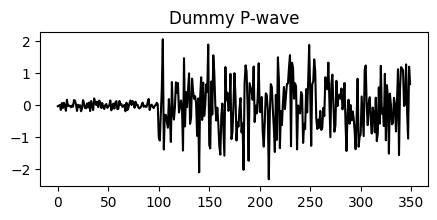

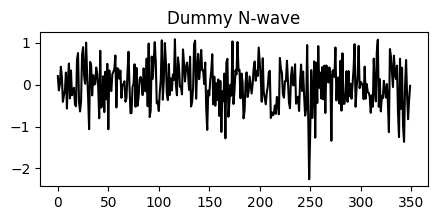

In [24]:
# Creating a dummy P wave
noise = tf.random.normal((500,100), mean=0, stddev=0.1)
phase = tf.random.normal((500,250), mean=0, stddev=0.8)
dummy_X = tf.concat([noise, phase], axis=1)

# plotting dummy P wave
f, ax = plt.subplots(1, 1, figsize=(5,2))
ax.plot(dummy_X[0], color='black')
plt.title('Dummy P-wave')
plt.show()

# Creating a dummy N wave
dummy_Xn = tf.random.normal((500,350), mean=0, stddev=0.5)

# plotting dummy N wave
f, ax = plt.subplots(1, 1, figsize=(5,2))
ax.plot(dummy_Xn[0], color='black')
plt.title('Dummy N-wave')
plt.show()

Now we convert these data into a tensorflow dataset. With tensorflow dataset, we can work with all the methods provided by ```tf.data``` modules, which can benefit our training preparation and process. Next, we batch them to create minibatches.

In [25]:
p_dataset = tf.data.Dataset.from_tensor_slices(dummy_X).batch(10)
n_dataset = tf.data.Dataset.from_tensor_slices(dummy_Xn).batch(10)

Let's test out our discriminator model before training

In [27]:
for p in p_dataset.take(1):
  predicted_values = tf.reshape(d_model(p), shape=[-1])
  avg = tf.math.reduce_mean(predicted_values)
  print(f'Average confidence for P wave: {avg}')

for p in p_dataset.take(1):
  predicted_values = tf.reshape(1 - d_model(p), shape=[-1])
  avg = tf.math.reduce_mean(predicted_values)
  print(f'Average confidence for N wave: {avg}')

Average confidence for P wave: 0.49919286370277405
Average confidence for N wave: 0.5008071660995483


2024-07-28 21:20:50.884203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-28 21:20:50.966286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Ignore the technical error messages, as you can see, the confidence for P wave prediction and N wave prediction is very low at the beginning. Now we begin with the mentioned training algorithm for just one epoch.

In [29]:
# nd, the discriminator training itteration
nd = 3

# ng, the generative training itteration
ng = 1

# optimizers
goptzr = tf.keras.optimizers.Adam(learning_rate=0.0009) # generative
doptzr = tf.keras.optimizers.Adam(learning_rate=0.0009) # discriminative

# The following for loop complies with the first step of our training algorithm.
# The variable p in this case is X^(p) and n is X^(n)
for (p, n) in zip(p_dataset.take(-1), n_dataset.take(-1)):

  # The following for loop exerts the second step.
  for _ in range(nd):
    d_update_tensors(p, n, d_model, doptzr)
  
  # The following for loop exerts the second step.
  for _ in range(ng):
    g_update_tensors(g_model, d_model, goptzr)
  pass

2024-07-28 20:01:39.824620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
for p in p_dataset.take(1):
  predicted_values = tf.reshape(d_model(p), shape=[-1])
  avg = tf.math.reduce_mean(predicted_values)
  print(f'Average confidence for P wave: {avg}')

for p in p_dataset.take(1):
  predicted_values = tf.reshape(1 - d_model(p), shape=[-1])
  avg = tf.math.reduce_mean(predicted_values)
  print(f'Average confidence for N wave: {1-avg}')

Average confidence for P wave: 1.0
Average confidence for N wave: 1.0


2024-07-28 20:01:43.360067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-28 20:01:43.434997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The confidence for both P wave and N wave detection is now significantly improved. This means that our trainable tensors are updated as expected.

# 4. The ```gtm``` Module

GTM stands for GAN Tutorial Module, which is a module made by the author that offers easability for constructing GAN and training GAN. The author has reconstructed all of the methods that we have gone through into three main modules which are ```gtm.models.GAN``` , ```gtm.models.discriminative``` and ```gtm.models.generative```. These moduls are designed to be as easy as possible to specifically design and train GAN for seismic P-phase detection. As we already have covered all the theoretical and basic practices of GAN, now we will delve into how to leverage this module. We will no longer delve into math anymore from this point on. Let's import the GTM module.

In [10]:
import gan_tutorial_modules as gtm
import sys

In [12]:
def gtm_update(gtm):
  pending_for_deletion = []
  for i in sys.modules:
    if i.split('.')[0] == 'gan_tutorial_modules':
      pending_for_deletion.append(i)

  for i in pending_for_deletion:
    del sys.modules[i]
  
  import gan_tutorial_modules as gtm
  return gtm

In [74]:
gtm = gtm_update(gtm)

## Configuring GAN

To initiate our training, we configure our GAN model using ```gtm.models.GAN()```. Take a look at the parameters that is required to initiate the ```gan``` class object. I assume that these parameters are easy to understand if you have understood quite well the tutorial we have gone through.

In [75]:
gan = gtm.models.GAN(epoch=5,
                    batch_size=10,
                    window_length=350,
                    generative_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009), 
                    discriminative_optimizer= tf.keras.optimizers.Adam(learning_rate=0.0009),
                    generative_total_iterations=3,
                    discriminative_total_iterations=4,
                    generative_latent_sample_size=50,
                    generative_latent_sample_mean=0,
                    generative_latent_sample_stdev=0.6,
                    p_wave_dataset=p_dataset,
                    n_wave_dataset=n_dataset
                    ) 
                    

We initiate the ```generative``` object class using ```gtm.models.Generative()```. The initiation process of this class requires ```gan``` object. This principle also applies for the ```discriminative``` object.

In [87]:
generative = gtm.models.Generative(gan)
discriminative = gtm.models.Discriminative(gan)

## Working with Models: Get Models and Update Models

By default, both of these objects already have sample models. These sample models are identical to the tutorial.

In [77]:
generative.model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vec_add_channel_14              │ (None, 50, 1)          │             0 │
│ (VecAddChannel)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_28             │ (None, 56, 2)          │            16 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_29             │ (None, 67, 4)          │           100 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_30             │ (None, 82, 8)          │           520 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_31             │ (None, 93, 6)          │           582 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 558)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 400)            │       223,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 350)            │       140,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,168 (1.39 MB)

 Trainable params: 365,168 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
discriminative.model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vec_add_channel_15              │ (None, 350, 1)         │             0 │
│ (VecAddChannel)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 346, 3)         │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 339, 4)         │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 330, 3)         │           123 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_7             │ (None, 165, 3)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 495)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │       126,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,482 (665.95 KB)

 Trainable params: 170,482 (665.95 KB)

 Non-trainable params: 0 (0.00 B)

You can update the model by calling method ```update_model```. Let's update the generator model with the following model.

In [81]:
# designing a new generator model
new_model_input = tf.keras.layers.Input(shape=(25,))
cont = tf.keras.layers.Dense(300)(new_model_input)
new_model_output = tf.keras.layers.Dense(355)(cont)

# creating a new generator model
new_model = tf.keras.Model(inputs=[new_model_input], outputs=[new_model_output])

# updating generator model in the generative object
generative.update_model(new_model)

Invalid input shape! Expected 50 but obtained 25
Invalid output shape! Expected 350 but obtained 355


As you can see, we have errors. These errors are raised because our model does not align with the configuration that we have set in advance in the ```GAN``` object initiation's parameters. Let's fix it and see the updated model.

In [83]:
# designing a new generator model
new_model_input = tf.keras.layers.Input(shape=(50,))
cont = tf.keras.layers.Dense(300)(new_model_input)
new_model_output = tf.keras.layers.Dense(350)(cont)

# creating a new generator model
new_model = tf.keras.Model(inputs=[new_model_input], outputs=[new_model_output])

# updating generator model in the generative object
generative.update_model(new_model)

generative.model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 300)            │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 350)            │       105,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,650 (471.29 KB)

 Trainable params: 120,650 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

Now the model is updated.

## Training GAN

Let's revert back our generative model into the default one.

In [86]:
generative = gtm.models.Generative(gan)

Dataset-wise, we will take the dummy dataset we have created to train our models.

In [88]:
for p in p_dataset.take(1):
  predicted_values = tf.reshape(discriminative.model(p), shape=[-1])
  avg = tf.math.reduce_mean(predicted_values)
  print(f'Average confidence for P wave: {avg}')

Average confidence for P wave: 0.47937408089637756


2024-07-28 22:08:31.852114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The output of the code above shows that our discriminative model still does not recognize our P wave. Let's train them by simply passing ```gan.train()```.

In [89]:
gan.train()

Epoch 1 out of 5


2024-07-28 22:10:00.466666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 50 batches per epoch
Epoch 2 out of 5


2024-07-28 22:10:33.640796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 50 batches per epoch
Epoch 3 out of 5


2024-07-28 22:11:05.022550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 50 batches per epoch
Epoch 4 out of 5


2024-07-28 22:11:37.900604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 50 batches per epoch
Epoch 5 out of 5
Found 50 batches per epoch


2024-07-28 22:12:09.888580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
for p in p_dataset.take(1):
  predicted_values = tf.reshape(discriminative.model(p), shape=[-1])
  avg = tf.math.reduce_mean(predicted_values)
  print(f'Average confidence for P wave: {avg}')

Average confidence for P wave: 0.9991582036018372


2024-07-28 22:23:14.446154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
